In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [10]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [11]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [12]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [13]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [14]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [15]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [16]:

class Particle:
    swarm_best_coloring = None
    swarm_best_value = None
    
    def __init__(self, graph, num_colors, c_i, c_p, c_s):
        self.c_i = c_i
        self.c_p = c_p
        self.c_s = c_s
        
        self.graph = graph
        self.num_colors = num_colors
        self.colors = np.random.randint(0, num_colors, len(graph.edges()))
        self.velocity = np.random.uniform(-1, 1, len(graph.edges()))
        
        self.personal_best_coloring = self.colors.copy()
        self.value = self.calculate_conflicts()
        self.personal_best_value = self.value
        self.personal_least_colors = self.num_colors
        if Particle.swarm_best_value is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_coloring = self.colors.copy()
            
    def calculate_conflicts(self):
        edge_color = {edge: self.colors[i] for i, edge in enumerate(self.graph.edges())}
        num = 0
    
        for edge in self.graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(self.graph, u)
            v_edges = neighbor_edges_of_node(self.graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1
        
        return len(self.graph.edges()) - num
    
    def update_colors(self):
        self.colors = np.clip(self.colors + self.velocity, 0, self.num_colors - 1).astype(int)
        self.value = self.calculate_conflicts()
        self.num_colors = len(np.unique(self.colors))
        if self.value < self.personal_best_value and is_valid_coloring(self.graph, self.colors) and self.num_colors < self.personal_least_colors:
            self.personal_best_value = self.value
            self.personal_best_coloring = self.colors.copy()
            self.personal_least_colors = self.num_colors
            
            if self.value < Particle.swarm_best_value :
                Particle.swarm_best_value = self.value
                Particle.swarm_best_coloring = self.colors.copy()
                
        else:
            return -100
    
    def update_velocity(self, iteration):
        cognitive_velocity = self.personal_best_coloring - self.colors
        social_velocity = Particle.swarm_best_coloring - self.colors
        r_p = np.random.random(len(cognitive_velocity))
        r_s = np.random.random(len(social_velocity))
        self.velocity = (self.c_i / iteration) * self.velocity + \
                        self.c_p * r_p * cognitive_velocity + \
                        self.c_s * r_s * social_velocity

In [17]:
def pso(graph, swarm_size, num_iters, c_i, c_p, c_s):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Inicijalno postavljamo broj boja na broj čvorova
    swarm = [Particle(graph, num_colors, c_i, c_p, c_s) for _ in range(swarm_size)]
    for i in range(num_iters):
        for p in swarm:
            p.update_velocity(i + 1)  # Povećavamo faktor c_i kako se iteracije povećavaju
            p.update_colors()
    return Particle.swarm_best_coloring, Particle.swarm_best_value, num_colors



In [18]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    swarm_size = 10  
    num_iters = 100  
    c_i = 0.5  
    c_p = 1 
    c_s = 1  

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, best_value, num_colors = pso(graph, swarm_size, num_iters, c_i, c_p, c_s)
            end_time = time.time()

            coloring_result = best_individual

            write_output(graph, file, coloring_result, num_colors, start_time, end_time) 
            Particle.swarm_best_coloring = None
            Particle.swarm_best_value = None

Running test graph_3_edges.txt...
[0 2 1]
Minimum edge coloring found.
Number of colors: 3
Number of iterations: 3


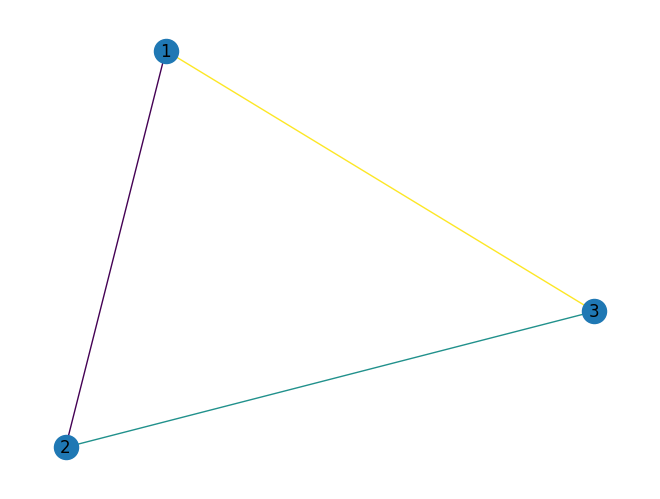

Time taken: 0.159027099609375 seconds

Running test graph_5_edges.txt...
[2 3 4 3 1]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 5


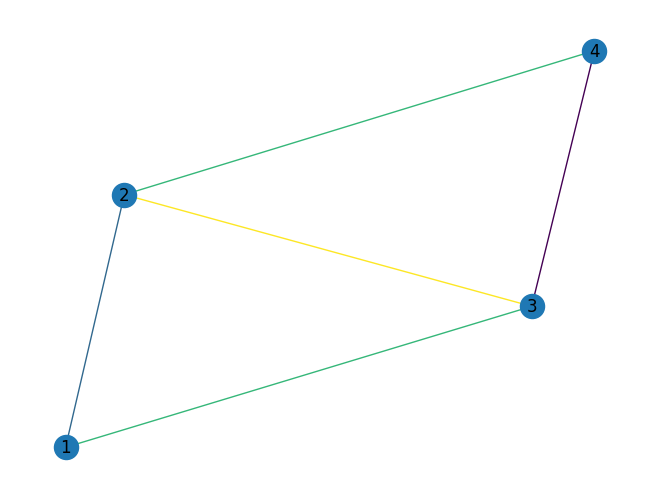

Time taken: 0.18674516677856445 seconds

Running test graph_5_edges_2.txt...
[4 0 1 2 4]
Minimum edge coloring found.
Number of colors: 4
Number of iterations: 5


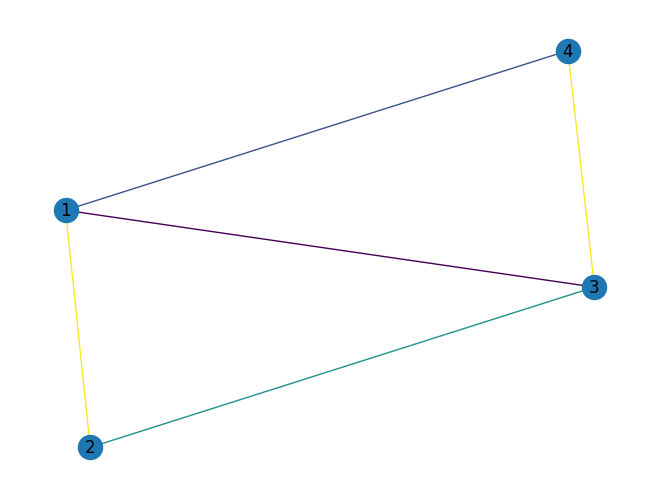

Time taken: 0.1773672103881836 seconds

Running test graph_6_edges.txt...
[4 2 0 3 5 5]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 6


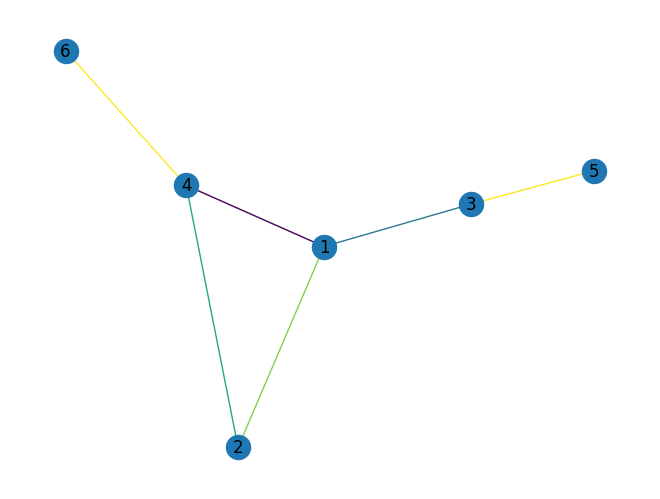

Time taken: 0.24986839294433594 seconds

Running test graph_7_edges.txt...
[6 3 0 5 4 2 1]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 7


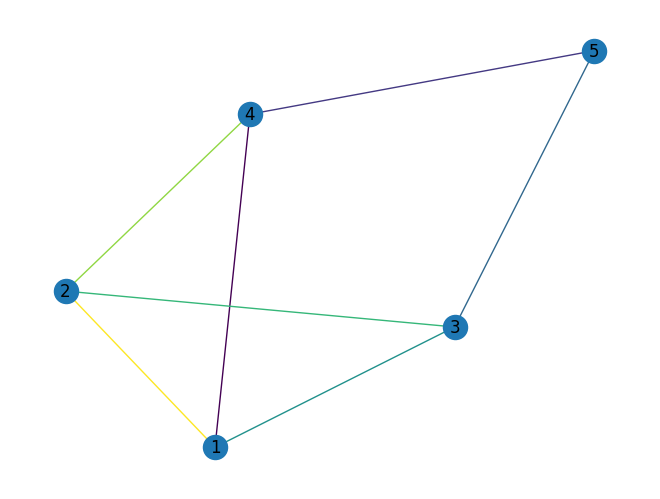

Time taken: 0.18322992324829102 seconds

Running test graph_7_edges_2.txt...
[3 2 5 4 2 3 0]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 7


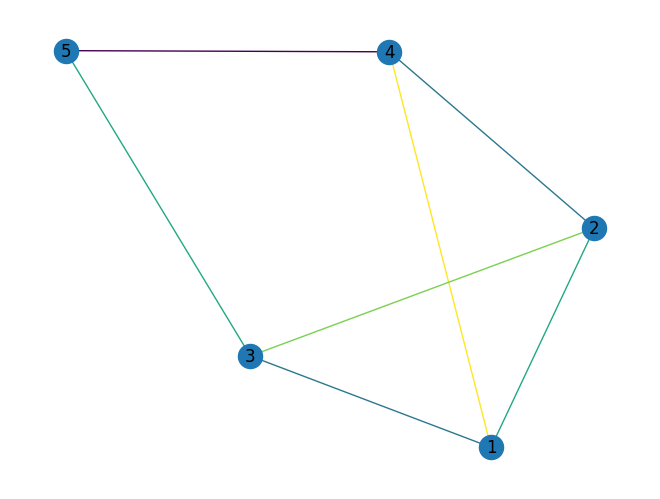

Time taken: 0.29337096214294434 seconds

Running test graph_7_edges_3.txt...
[6 3 5 1 4 1 6]
Minimum edge coloring found.
Number of colors: 5
Number of iterations: 7


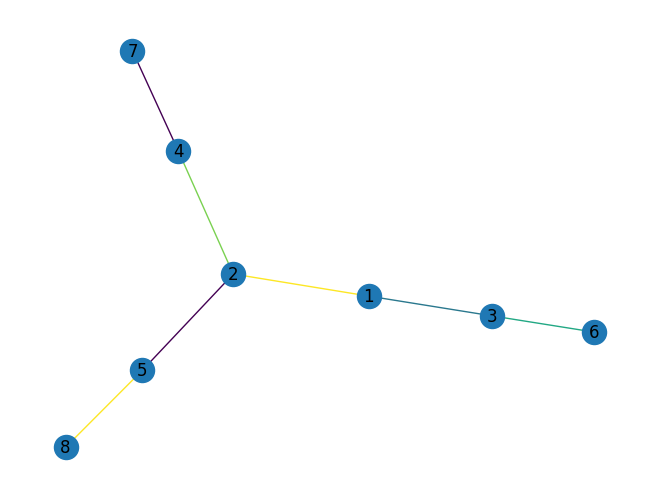

Time taken: 0.21457934379577637 seconds

Running test graph_8_edges.txt...
[7 6 3 1 1 7 2 4]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 8


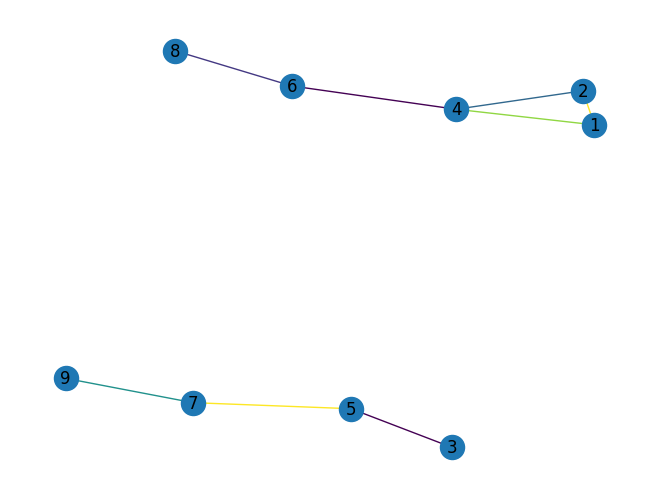

Time taken: 0.21852827072143555 seconds

Running test graph_9_edges.txt...
[7 5 0 1 1 6 6 5 4]
Minimum edge coloring found.
Number of colors: 6
Number of iterations: 9


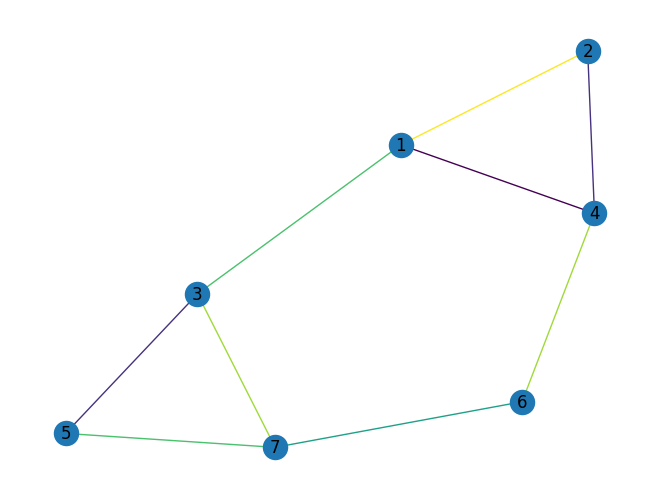

Time taken: 0.33266711235046387 seconds

Running test graph_9_edges_2.txt...
[3 5 1 0 0 6 7 4 7]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 9


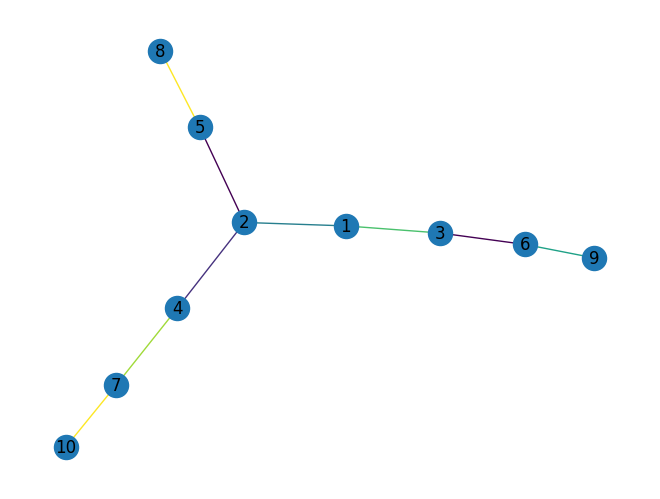

Time taken: 0.268369197845459 seconds

Running test graph_10_edges.txt...
[7 3 2 5 7 1 8 2 0 9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 10


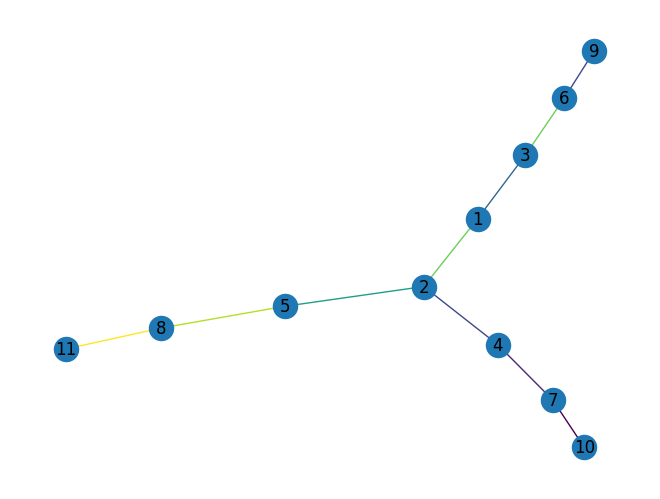

Time taken: 0.2904324531555176 seconds

Running test graph_10_edges_2.txt...
[4 0 1 6 5 3 9 7 0 9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 10


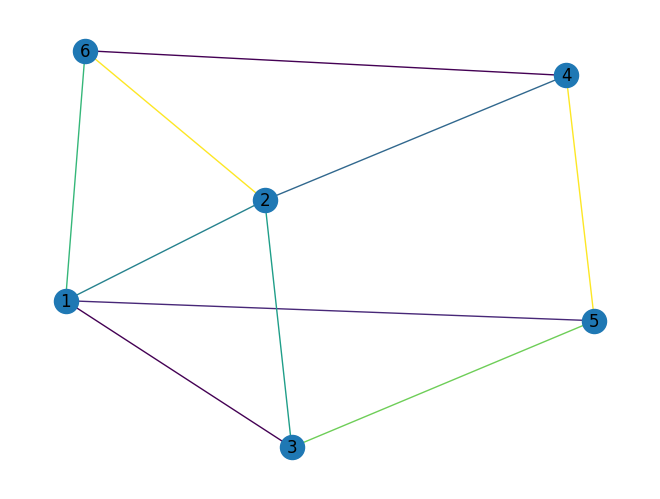

Time taken: 0.24349713325500488 seconds

Running test graph_10_edges_3.txt...
[2 7 9 4 4 1 6 3 5 9]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 10


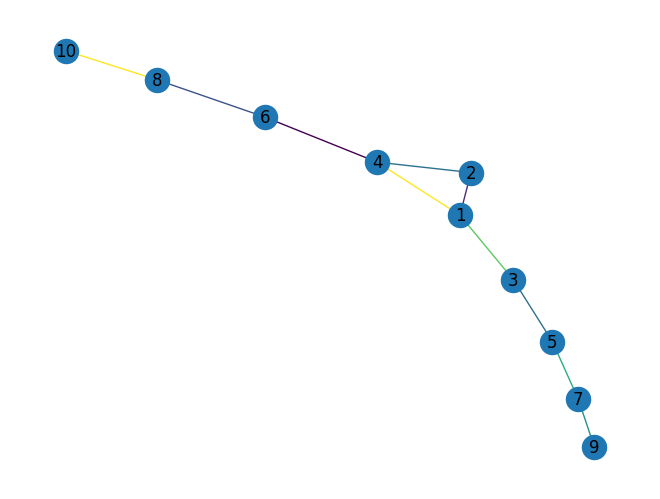

Time taken: 0.2627429962158203 seconds

Running test graph_11_edges.txt...
[ 4  6  5  5  7  3  9 10  8  1  2]
Minimum edge coloring found.
Number of colors: 10
Number of iterations: 11


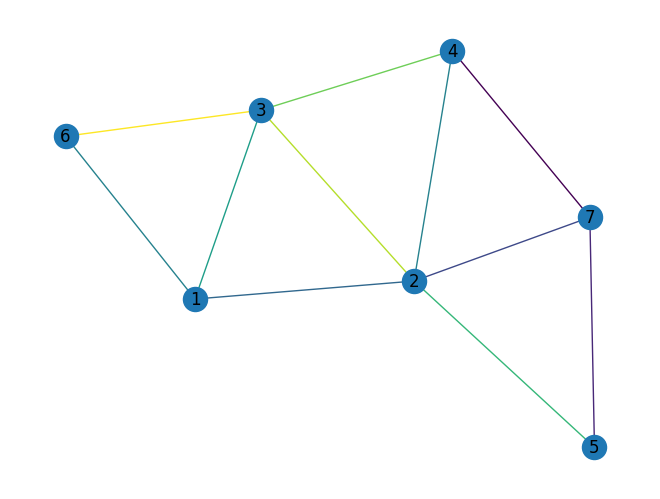

Time taken: 0.31621623039245605 seconds

Running test graph_11_edges_2s.txt...
[ 7  1  9  2  1  3  6 10  9  0  0]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 11


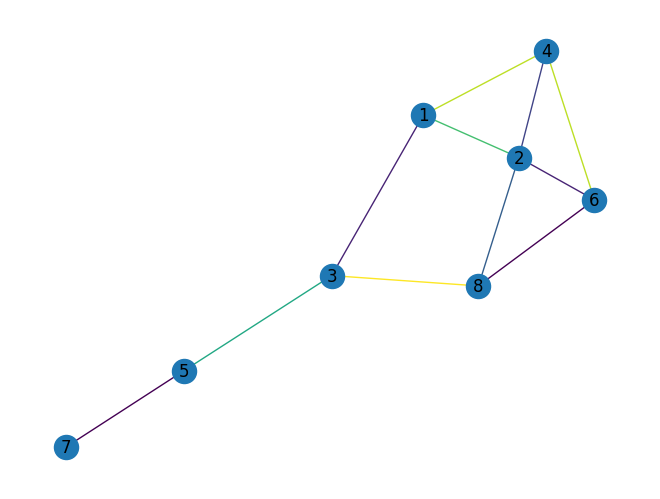

Time taken: 0.35199546813964844 seconds

Running test graph_11_edges_3.txt...
[5 6 7 2 1 9 0 4 2 2 8]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 11


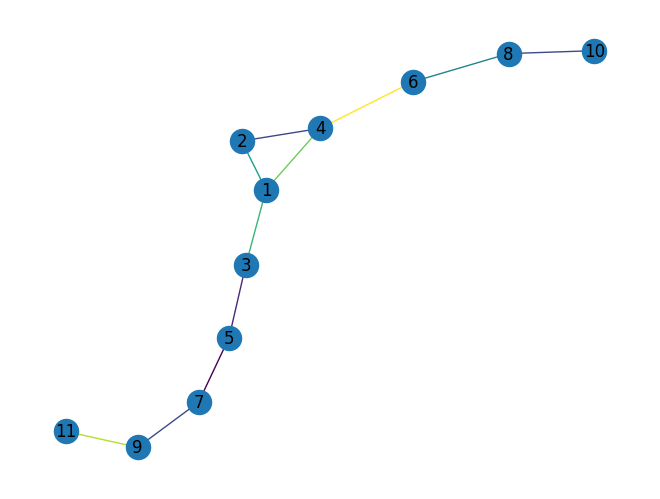

Time taken: 0.40129852294921875 seconds

Running test graph_11_edges_4.txt...
[10  2  7  3  3 10  4  8  9  7  3]
Minimum edge coloring found.
Number of colors: 7
Number of iterations: 11


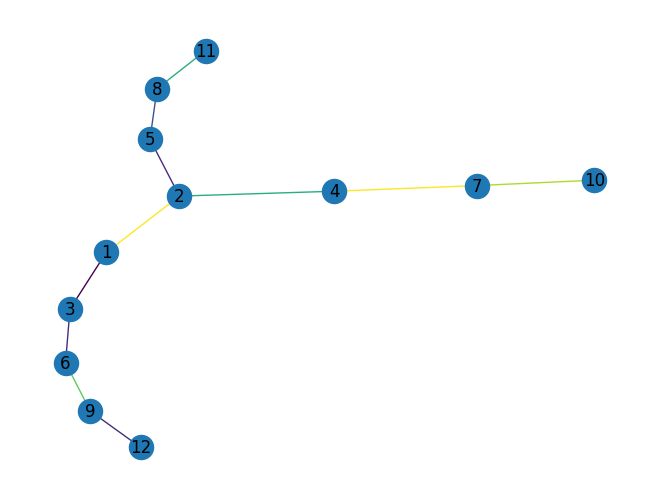

Time taken: 0.3260369300842285 seconds

Running test graph_12_edges.txt...
[ 3  7 10 11  3  7  2  2  6  8  3  1]
Minimum edge coloring found.
Number of colors: 8
Number of iterations: 12


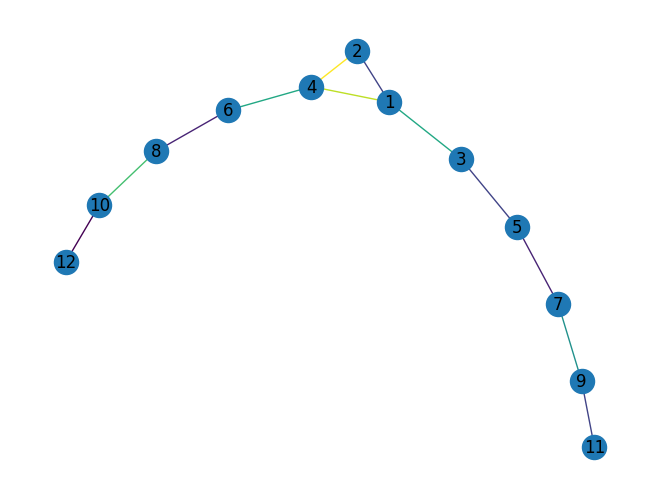

Time taken: 0.3399319648742676 seconds

Running test graph_12_edges_2.txt...
[ 4  2  9  8  7  4  5  1  9  0  0 10]
Minimum edge coloring found.
Number of colors: 9
Number of iterations: 12


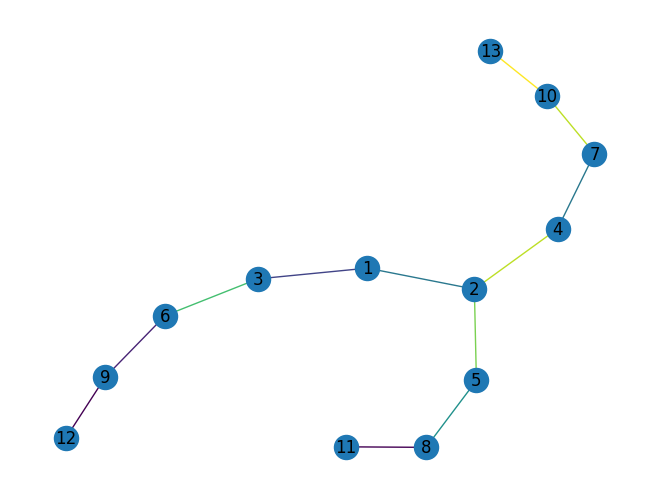

Time taken: 0.4529900550842285 seconds

Running test graph_15_edges.txt...
[ 4 13  2  5  6  9  6  9  4 13  8  7 10  3 12]
Minimum edge coloring found.
Number of colors: 11
Number of iterations: 15


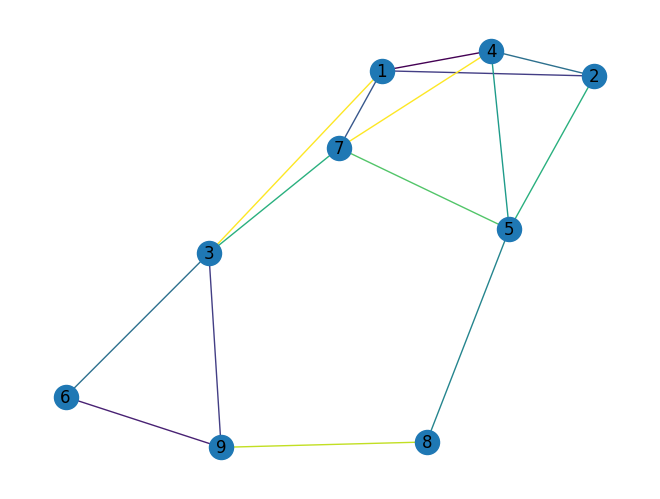

Time taken: 0.48593974113464355 seconds



In [19]:
with open('./results/pso_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')